In [256]:
from math import sin, cos, pi
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from IPython.display import display, Latex

In [257]:
# ---------------------------------------------------------------------------
#                         Initializing DH Parameters (at rest position)
# ---------------------------------------------------------------------------

# Initializing/Declaring Parameter - a (mm)
a1 = 260; a2 = 680; a3 = -35

# Initializing/Declaring Parameter - alpha (rad)
alp1 = -pi/2
alp2 = 0
alp3 = -pi/2
alp4 = pi/2
alp5 = -pi/2
alp6 = 0

# Initializing/Declaring Parameter - d (mm)
d1 = 675; d4 = 670; d6 = 115
p  = 250       # length of paint nozzle end-effector

# Initializing/Declaring Parameter - theta (rad)
q1 = 0
q2 = 0
q3 = 0 - pi/2
q4 = 0
q5 = 0
q6 = 0


In [258]:
# ---------------------------------------------------------------------------
#                           Defining Functions
# ---------------------------------------------------------------------------

# Function to compute homogeneous transformation matrix using DH parameters
def T_i_matrix(a, alp, d, theta):
    T = np.array([[cos(theta), -sin(theta)*cos(alp), sin(theta)*sin(alp), a*cos(theta)],
                [sin(theta), cos(theta)*cos(alp), -cos(theta)*sin(alp), a*sin(theta)],
                [0, sin(alp), cos(alp), d],
                [0, 0, 0, 1]])
    return T

# Function to retrieve Z vectors from homogeneous transformation matrices
def Z_i_column(T):
    return np.array(T[0:3, 2])

# Function to retrieve O vectors from homogeneous transformation matrices
def O_i_column(T):
    return np.array(T[0:3, 3])

# Function to generate Jacobian matrix columns 
def J_i_matrix(Z, O, On):
  return np.concatenate([np.cross(Z, (On - O)), Z])


In [259]:
# ---------------------------------------------------------------------------
#               end effector velocities for each iteration (makes line)
# ---------------------------------------------------------------------------

# Defining charateristics for line tracking
n = 50                       # Number of iterations
time = 5                    # [seconds], time to make a line
l = 100                     # length of line (mm)
del_t = time/n              # time step
del_dist = l/n              # distance step

q_prev = np.array([[q1, q2, q3, q4, q5, q6]]).transpose() # Initializing q_prev

y_dot_ = list()    #  list for y_dot values
z_dot_ = list()    #  list for z_dot values

line_y = [0]       # line y coordinates
line_z = [1320]     # line z coordinates

end_y = [0]        # End-Effector y coordinates
end_z = [1320]      # End-Effector z coordinates

In [260]:
for i in range(n):

    # Computing Homogeneous Transformation Matrices
    T1 = T_i_matrix(a1, alp1, d1, q_prev[0])
    T2 = T_i_matrix(a2, alp2, 0, q_prev[1])
    T3 = T_i_matrix(a3, alp3, 0, q_prev[2])
    T4 = T_i_matrix(0, alp4, d4, q_prev[3])
    T5 = T_i_matrix(0, alp5, 0, q_prev[4])
    T6 = T_i_matrix(0, alp6, d6+p, q_prev[5])

    T_01 = T1
    T_12 = np.matmul(T_01, T2)
    T_23 = np.matmul(T_12, T3)
    T_34 = np.matmul(T_23, T4)
    T_45 = np.matmul(T_34, T5)
    T_56 = np.matmul(T_45, T6)

    # Computing Z vectors from Transformation Matrices
    Z0 = np.array([0, 0, 1])
    Z1 = Z_i_column(T_01)
    Z2 = Z_i_column(T_12)
    Z3 = Z_i_column(T_23)
    Z4 = Z_i_column(T_34)
    Z5 = Z_i_column(T_45)
    Z6 = Z_i_column(T_56)

    # Computing O vectors from Transformation Matrices
    O0 = np.array([0, 0, 0])
    O1 = O_i_column(T_01)
    O2 = O_i_column(T_12)
    O3 = O_i_column(T_23)
    O4 = O_i_column(T_34)
    O5 = O_i_column(T_45)
    O6 = O_i_column(T_56)
    
    # Computing Ji
    J1 = J_i_matrix(Z0, O0, O6)
    J2 = J_i_matrix(Z1, O1, O6)
    J3 = J_i_matrix(Z2, O2, O6)
    J4 = J_i_matrix(Z3, O3, O6)
    J5 = J_i_matrix(Z4, O4, O6)
    J6 = J_i_matrix(Z5, O5, O6)

    J = np.array([J1, J2, J3, J4, J5, J6]).transpose()
    J_ = np.linalg.pinv(J) # Taking the pseudo-inverse of the Jacobian Matrix
                  
    J1 = sym.Matrix(J1)
    J2 = sym.Matrix(J2)
    J3 = sym.Matrix(J3)
    J4 = sym.Matrix(J4)
    J5 = sym.Matrix(J5)
    J6 = sym.Matrix(J6)
    
    # J_mat = sym.Matrix.hstack(J1, J2, J3, J4, J5, J6)
    # display(J_mat)
   
    # ---------------------------------------------------------------------------
    #                      computing points on the LINE 
    # ---------------------------------------------------------------------------

    line_y.append(0)
    y_dot = 0
    y_dot_.append(y_dot)
    
    line_z.append(1320 - n*del_dist)
    z_dot = del_dist/del_t
    z_dot_.append(z_dot)
    
    # ---------------------------------------------------------------------------
    #                        Inverse Kinematics
    # ---------------------------------------------------------------------------
    
    eta = np.array([[y_dot, 0, z_dot, 0, 0, 0]]).transpose()
    q_curr_dot = np.matmul(J_, eta)
    q_curr = q_prev + q_curr_dot * del_t
    q_prev = q_curr

    # ---------------------------------------------------------------------------
    #                        Forward Kinematics
    # ---------------------------------------------------------------------------
    
    y = end_y[i] - y_dot_[i] * del_t
    end_y.append(y)
    z = end_z[i] - z_dot_[i] * del_t
    end_z.append(z)    


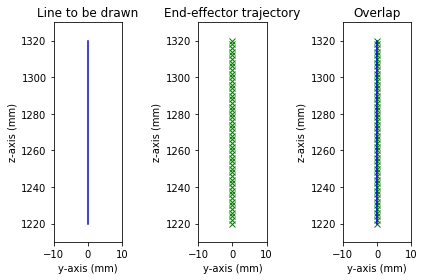

In [261]:
# ---------------------------------------------------------------------------
#                          Building Plots for Validation
# ---------------------------------------------------------------------------

fig, axs = plt.subplots(1, 3)
axs[0].plot(line_y, line_z, 'b-')
axs[0].axis([-10,10,1210,1330])
axs[0].set_title("Line to be drawn")
axs[0].set_xlabel("y-axis (mm)")
axs[0].set_ylabel("z-axis (mm)")

axs[1].plot(end_y, end_z, 'gx')
axs[1].axis([-10,10,1210,1330])
axs[1].set_title("End-effector trajectory")
axs[1].set_xlabel("y-axis (mm)")
axs[1].set_ylabel("z-axis (mm)")

axs[2].plot(end_y, end_z, 'gx')
axs[2].plot(line_y, line_z, 'b-')
axs[2].axis([-10,10,1210,1330])
axs[2].set_title("Overlap")
axs[2].set_xlabel("y-axis (mm)")
axs[2].set_ylabel("z-axis (mm)")

fig.tight_layout()
